In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
import torch
import pickle
import networkx as nx
import numpy as np
import os

seeds = [6, 7, 10, 11, 19, 22, 31, 42, 666, 888]
splitFilePrefix = '_x86_64_withVal_withPretrain_ghidra_'


## Simple Graph2Vec Experiments

### Functions

In [6]:
class WLGraph2Vec:
    def __init__(self, num_iterations=3):
        """
        初始化 WL Graph2Vec
        
        參數:
            num_iterations: WL迭代次數
        """
        self.num_iterations = num_iterations
        
    def _wl_iteration(self, G, node_features):
        """執行一次WL迭代"""
        new_features = {}
        
        for node in G.nodes():
            # 獲取節點當前特徵
            current_feature = node_features[node]
            
            # 收集所有鄰居的特徵
            neighbor_features = []
            for neighbor in G.neighbors(node):
                neighbor_features.append(node_features[neighbor])
            
            if neighbor_features:
                # 計算鄰居特徵的平均值
                neighbor_mean = np.mean(neighbor_features, axis=0)
                # 組合當前節點特徵和鄰居特徵
                new_feature = 0.5 * current_feature + 0.5 * neighbor_mean
            else:
                new_feature = current_feature
                
            new_features[node] = new_feature
            
        return new_features

    def transform(self, G):
        """
        使用WL機制將圖轉換為128維向量
        
        參數:
            G: networkx圖物件，節點的'x'屬性包含tensor特徵
        返回:
            numpy.ndarray: 128維向量
        """
        # 初始化節點特徵
        node_features = {}
        for node in G.nodes():
            if isinstance(G.nodes[node]['x'], torch.Tensor):
                node_features[node] = G.nodes[node]['x'].numpy()
            else:
                node_features[node] = np.array(G.nodes[node]['x'])
        
        # 儲存每次迭代的圖級別特徵
        graph_features = []
        
        # WL迭代
        for _ in range(self.num_iterations):
            # 更新節點特徵
            node_features = self._wl_iteration(G, node_features)
            
            # 計算當前迭代的圖級別特徵
            current_features = np.array(list(node_features.values()))
            graph_features.append(np.mean(current_features, axis=0))
            graph_features.append(np.max(current_features, axis=0))
            graph_features.append(np.min(current_features, axis=0))
        
        # 組合所有特徵
        combined_features = np.concatenate(graph_features)
        
        # 如果特徵維度不是128，則需要調整
        if len(combined_features) > 128:
            # 使用平均池化減少維度
            splits = np.array_split(combined_features, 128)
            final_vector = np.array([np.mean(split) for split in splits])
        elif len(combined_features) < 128:
            # 使用線性插值增加維度
            original_positions = np.linspace(0, 1, len(combined_features))
            new_positions = np.linspace(0, 1, 128)
            final_vector = np.interp(new_positions, original_positions, combined_features)
        else:
            final_vector = combined_features
            
        # 標準化最終向量
        if np.std(final_vector) != 0:
            final_vector = (final_vector - np.mean(final_vector)) / np.std(final_vector)
        else:
            final_vector = final_vector - np.mean(final_vector)

        return final_vector

In [7]:
from torch_geometric.utils.convert import from_networkx
def load_split_data(seed):
    """
    載入訓練集、驗證集和測試集
    
    參數:
        seed: 隨機種子
    返回:
        tuple: (訓練集, 驗證集, 測試集)
    """
    path = "/home/manying/Projects/fcgFewShot/dataset/split"

    train_file = os.path.join(path, 'train'+ splitFilePrefix + str(seed) + '.txt')
    val_file = os.path.join(path, 'val'+ splitFilePrefix + str(seed) + '.txt')
    test_file = os.path.join(path, 'test'+ splitFilePrefix + str(seed) + '.txt')
    

    train_data = []
    with open(train_file, 'r') as f:
        for line in f:
            train_data.append(line.strip())
    
    val_data = []

    with open(val_file, 'r') as f:
        for line in f:
            val_data.append(line.strip())
    
    test_data = []
    with open(test_file, 'r') as f:
        for line in f:
            test_data.append(line.strip())
        
    return train_data, val_data, test_data 

def load_dataset(familyList, seed):
    """
    載入圖數據集
    
    參數:
        familyList: list of str, 指定要載入的家族名稱
    返回:
        list of networkx.Graph: 圖數據集
    """
    path = f"/home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/Advanced Micro Devices X86-64"
    graphs = []
    labels = []
    paths = []
    for family in familyList:
        graph_folder = os.path.join(path, family)
        for graph_file in os.listdir(graph_folder):
            if graph_file.endswith('.gpickle'):
                graph = load_graph(os.path.join(graph_folder, graph_file))
                graphs.append(graph)
                labels.append(family)
                paths.append(os.path.join(graph_folder, graph_file))
    return graphs, labels, paths

def load_graph(path):
    with open(path, "rb") as f:
        fcg = pickle.load(f)
        for node in fcg.nodes:
            if len(fcg.nodes[node]["x"]) == 0:
                fcg.nodes[node]["x"] = torch.zeros(128, dtype=torch.float32)
            if not isinstance(fcg.nodes[node]["x"], torch.Tensor):
                fcg.nodes[node]["x"] = torch.tensor(fcg.nodes[node]["x"], dtype=torch.float32)
    return fcg


In [8]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict
import random

def evaluate_few_shot(test_vectors, test_labels, n_episodes=100, mode="Nn"):
    """
    評估few-shot learning的平均準確率
    
    參數:
        test_vectors: 測試數據向量
        test_labels: 測試數據標籤
        n_episodes: 評估回合數
    """
    # 整理每個類別的樣本索引
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(test_labels):
        label_to_indices[label].append(idx)
    
    def run_episode(n_way, n_shot):
        # 計算query樣本數量：共20個樣本減去support set的數量
        n_query = 20 - n_shot
        
        # 隨機選擇n_way個類別
        selected_classes = random.sample(list(label_to_indices.keys()), n_way)
        support_X = []
        support_y = []
        query_X = []
        query_y = []
        
        # 對每個選中的類別採樣數據
        for cls in selected_classes:
            cls_indices = label_to_indices[cls]
            selected_indices = random.sample(cls_indices, n_shot + n_query)
            
            # 分割support set和query set
            support_indices = selected_indices[:n_shot]
            query_indices = selected_indices[n_shot:]
            
            # 收集數據
            support_X.extend([test_vectors[idx] for idx in support_indices])
            support_y.extend([cls] * n_shot)
            query_X.extend([test_vectors[idx] for idx in query_indices])
            query_y.extend([cls] * n_query)
        
        # 轉換為numpy數組
        support_X = np.array(support_X)
        support_y = np.array(support_y)
        query_X = np.array(query_X)
        query_y = np.array(query_y)

        if mode == "Proto":
            # 計算每個類別的原型向量
            prototypes = []
            for cls in selected_classes:
                cls_indices = np.where(support_y == cls)[0]
                cls_vectors = support_X[cls_indices]
                prototype = np.mean(cls_vectors, axis=0)
                prototypes.append(prototype)
            prototypes = np.array(prototypes)

            # 計算每個query樣本到原型向量的歐幾里得距離
            distances = np.linalg.norm(query_X[:, None] - prototypes, axis=2)
            predictions = np.argmin(distances, axis=1)
            predictions = np.array([selected_classes[pred] for pred in predictions])
            
        elif mode == "Nn":
            # 訓練和預測
            classifier = KNeighborsClassifier(n_neighbors=1)
            classifier.fit(support_X, support_y)
            predictions = classifier.predict(query_X)
        
        # 計算準確率
        accuracy = np.mean(predictions == query_y)
        confusion_matrix = np.zeros((10, 10))

        if mode == "Proto" and n_way == 10 and n_shot == 5:
            ## generate confusion matrix in 10-way 5-shot
            for i in range(len(predictions)):
                confusion_matrix[query_y[i]][predictions[i]] += 1
            confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None]

        return accuracy, confusion_matrix
    
    # 評估所有配置
    configs = [(5, 5), (10, 5), (5, 10), (10, 10)]
    results = {}
    
    for n_way, n_shot in configs:
        # 運行n_episodes次並計算平均準確率
        if mode == "Proto":
            accuracies = []
            confusion_matrix = np.zeros((10, 10))
            for _ in range(n_episodes):
                accuracy, confusion_matrix = run_episode(n_way, n_shot)
                accuracies.append(accuracy)
                confusion_matrix += confusion_matrix
            results[f"{n_way}-way {n_shot}-shot"] = np.mean(accuracies), confusion_matrix / n_episodes
        elif mode == "Nn":
            accuracies = [run_episode(n_way, n_shot)[0] for _ in range(n_episodes)]
            results[f"{n_way}-way {n_shot}-shot"] = np.mean(accuracies)
        
    return results

### Generate Dataset

In [9]:
## Gen data

dataset = {}

for seed in seeds:
    train_data, val_data, test_data = load_split_data(seed)
    print('seed:', seed)

    test_graphs, test_labels, test_paths = load_dataset(test_data, seed)
    print("Converting graphs to vectors...")

    graph2vec = WLGraph2Vec(num_iterations=3)
    # train_vectors = [graph2vec.transform(graph) for graph in train_graphs]
    test_vectors = [graph2vec.transform(graph) for graph in test_graphs]
    # train_vectors = np.array(train_vectors)
    test_vectors = np.array(test_vectors)

    dataset[seed] = (test_vectors, test_labels, test_paths)


seed: 6


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Converting graphs to vectors...
seed: 7
Converting graphs to vectors...
seed: 10
Converting graphs to vectors...
seed: 11
Converting graphs to vectors...
seed: 19
Converting graphs to vectors...
seed: 22
Converting graphs to vectors...
seed: 31
Converting graphs to vectors...
seed: 42
Converting graphs to vectors...
seed: 666
Converting graphs to vectors...
seed: 888
Converting graphs to vectors...


### Nn Experiements

In [10]:
final_results = {}

for seed in seeds:
    test_vectors = dataset[seed][0]
    test_labels = dataset[seed][1]
    test_paths = dataset[seed][2]

    print(f"Seed: {seed}")
    # label encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(test_labels)
    test_labels = label_encoder.transform(test_labels)

    results = evaluate_few_shot(test_vectors, test_labels, n_episodes=1000, mode="Nn")

    for config, acc in results.items():
        print(f"{config}: {acc}")

    final_results[seed] = results


Seed: 6
5-way 5-shot: 0.7682133333333334
10-way 5-shot: 0.6999266666666666
5-way 10-shot: 0.8368800000000001
10-way 10-shot: 0.7638400000000001
Seed: 7
5-way 5-shot: 0.9198799999999999
10-way 5-shot: 0.8832133333333334
5-way 10-shot: 0.94086
10-way 10-shot: 0.9177099999999999
Seed: 10
5-way 5-shot: 0.89288
10-way 5-shot: 0.84708
5-way 10-shot: 0.9121400000000001
10-way 10-shot: 0.8795499999999999
Seed: 11
5-way 5-shot: 0.9643999999999998
10-way 5-shot: 0.9495399999999999
5-way 10-shot: 0.9784200000000001
10-way 10-shot: 0.97028
Seed: 19
5-way 5-shot: 0.8937466666666667
10-way 5-shot: 0.8666533333333334
5-way 10-shot: 0.9306000000000001
10-way 10-shot: 0.9065899999999999
Seed: 22
5-way 5-shot: 0.8543466666666666
10-way 5-shot: 0.8079400000000001
5-way 10-shot: 0.89176
10-way 10-shot: 0.8508
Seed: 31
5-way 5-shot: 0.8920266666666666
10-way 5-shot: 0.8348933333333334
5-way 10-shot: 0.89654
10-way 10-shot: 0.8434100000000001
Seed: 42
5-way 5-shot: 0.8649466666666666
10-way 5-shot: 0.8094
5

In [11]:
# calculate average results
average_results = defaultdict(float)
for seed, results in final_results.items():
    for config, acc in results.items():
        average_results[config] += acc

for config, acc in average_results.items():
    average_results[config] = acc / len(seeds)

print("\nAverage results:")
for config, acc in average_results.items():
    print(f"{config}: {acc}")


Average results:
5-way 5-shot: 0.8787906666666666
10-way 5-shot: 0.8284546666666668
5-way 10-shot: 0.9100900000000001
10-way 10-shot: 0.866737


### Proto Experiments

In [12]:
## Proto mode

final_results = {}

for seed in seeds:

    test_vectors = dataset[seed][0]
    test_labels = dataset[seed][1]
    test_paths = dataset[seed][2]
    print('seed:', seed)
    # label encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(test_labels)
    test_labels = label_encoder.transform(test_labels)

    results = evaluate_few_shot(test_vectors, test_labels, n_episodes=1000, mode="Proto")

    for config, result in results.items():
        print(f"{config}: {result[0]}")
        # if config == "10-way 5-shot":
        #     print(result[1])


    final_results[seed] = results

seed: 6


5-way 5-shot: 0.6821733333333333
10-way 5-shot: 0.5899533333333333
5-way 10-shot: 0.70338
10-way 10-shot: 0.6131899999999999
seed: 7
5-way 5-shot: 0.8536933333333333
10-way 5-shot: 0.8010066666666666
5-way 10-shot: 0.8678400000000001
10-way 10-shot: 0.80723
seed: 10
5-way 5-shot: 0.8451733333333333
10-way 5-shot: 0.7605999999999999
5-way 10-shot: 0.8528000000000001
10-way 10-shot: 0.76235
seed: 11
5-way 5-shot: 0.9332133333333333
10-way 5-shot: 0.9115866666666667
5-way 10-shot: 0.9308
10-way 10-shot: 0.91503
seed: 19
5-way 5-shot: 0.8322666666666666
10-way 5-shot: 0.7784266666666666
5-way 10-shot: 0.85102
10-way 10-shot: 0.80875
seed: 22
5-way 5-shot: 0.74608
10-way 5-shot: 0.6821333333333334
5-way 10-shot: 0.7609799999999999
10-way 10-shot: 0.6992299999999999
seed: 31
5-way 5-shot: 0.8121866666666667
10-way 5-shot: 0.7429866666666666
5-way 10-shot: 0.8040800000000001
10-way 10-shot: 0.7499600000000001
seed: 42
5-way 5-shot: 0.8226133333333333
10-way 5-shot: 0.7193066666666666
5-way 10

In [13]:
# calculate average results
average_results = defaultdict(float)
for seed, results in final_results.items():
    for config, result in results.items():
        average_results[config] += result[0]

for config, acc in average_results.items():
    average_results[config] = acc / len(seeds)

print("\nAverage results:")
for config, acc in average_results.items():
    print(f"{config}: {acc}")


Average results:
5-way 5-shot: 0.8095213333333332
10-way 5-shot: 0.7327953333333334
5-way 10-shot: 0.81745
10-way 10-shot: 0.745579


## Visualize TSNE

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import re

def visualize_tsne(test_vectors, test_labels, seed, mode):
    """
    使用t-SNE將高維向量視覺化，並在proto模式下標示prototype位置和support points
    
    參數:
        test_vectors: numpy array of shape (n_samples, n_features)
        test_labels: numpy array of shape (n_samples,)
        seed: 當前的隨機種子
        mode: 模式名稱，用於確定是否需要顯示prototype
    """
    # 設置隨機種子
    np.random.seed(seed)
    
    # 確保數據是numpy數組
    test_vectors = np.array(test_vectors)
    test_labels = np.array(test_labels)
    
    # 標準化數據
    scaler = StandardScaler()
    test_vectors_scaled = scaler.fit_transform(test_vectors)
    
    # 應用t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42,
        init='pca',
        learning_rate='auto'
    )
    
    # 轉換數據
    test_vectors_tsne = tsne.fit_transform(test_vectors_scaled)
    
    plt.figure(figsize=(12, 8))
    
    # 使用不同的配色方案
    n_classes = len(np.unique(test_labels))
    colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 如果模式包含"proto"，先計算prototype位置和記錄support points
    prototypes = {}
    support_points = {}
    if 'proto' in mode.lower():
        shot_match = re.search(r'(\d+)s', mode)
        if shot_match:
            n_shots = int(shot_match.group(1))
            for i, label in enumerate(np.unique(test_labels)):
                mask = test_labels == label
                class_vectors = test_vectors_tsne[mask]
                if len(class_vectors) >= n_shots:
                    support_indices = np.random.choice(len(class_vectors), n_shots, replace=False)
                    support_vectors = class_vectors[support_indices]
                    prototypes[label] = np.mean(support_vectors, axis=0)
                    support_points[label] = support_vectors
    
    # 一次性繪製所有數據點、support points和prototype
    for i, label in enumerate(np.unique(test_labels)):
        mask = test_labels == label
        # 繪製該類別的所有數據點（空心圓）
        plt.scatter(
            test_vectors_tsne[mask, 0],
            test_vectors_tsne[mask, 1],
            c='None',
            edgecolors=[colors[i]],
            label=f'Family {label}',
            alpha=1.0,
            s=100,
            linewidth=1.5
        )
        
        # 如果有support points，繪製support points（實心圓）
        if label in support_points:
            support = support_points[label]
            plt.scatter(
                support[:, 0],
                support[:, 1],
                c=[colors[i]],
                marker='o',
                s=100,
                alpha=0.7,
                label=f'Support {label}'
            )
        
        # 如果有prototype，繪製prototype點（X標記）
        if label in prototypes:
            prototype = prototypes[label]
            plt.scatter(
                prototype[0],
                prototype[1],
                c=[colors[i]],
                marker='x',
                s=200,
                linewidth=3,
                label=f'Prototype {label}'
            )
    
    # 添加標題和標籤
    plt.title(f"t-SNE Visualization (Seed {seed})", fontsize=14, pad=20)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    
    # 調整圖例
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        title="Malware Families",
        title_fontsize=12,
        fontsize=10
    )
    
    # 調整布局
    plt.tight_layout()
    
    # 保存圖片
    os.makedirs(f"./tsne_pic/{mode}", exist_ok=True)
    plt.savefig(f"./tsne_pic/{mode}/tsne_{mode}_seed_{seed}.png")
    # 關閉圖形以釋放內存
    plt.close()

### Plot grah2vec data distribution

In [36]:
# 使用示例
for seed in seeds:

    print('Seed:', seed)
    
    test_vectors = dataset[seed][0]
    test_labels = dataset[seed][1]
    test_paths = dataset[seed][2]
    
    # 檢查並處理NaN值
    if np.isnan(test_vectors).any():
        print("Warning: Found NaN values in vectors, replacing with 0")
        test_vectors = np.nan_to_num(test_vectors, nan=0.0)
    
    # 視覺化
    visualize_tsne(test_vectors, test_labels, seed, mode="graph2vec")

Seed: 6
Seed: 7
Seed: 10
Seed: 11
Seed: 19
Seed: 22
Seed: 31
Seed: 42
Seed: 666
Seed: 888


### Plot random graphSAGE distribution

In [26]:
import numpy as np
import pickle
from models import GraphSAGE, GCN
from torch_geometric.data import Batch

for seed in seeds:
    path = f"/home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/testData.pkl"
    with open(path, "rb") as f:
        data = pickle.load(f)
        data_list = data[0]
        label = data[1]
    labelDictPath = f"/home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/labelDict.pkl"
    with open(labelDictPath, "rb") as f:
        labelDict = pickle.load(f)
    print(f"Seed: {seed}")
    label = label.astype(str)
    for key, value in labelDict.items():
        label[label == str(value)] = key
        
    model = GraphSAGE(dim_in=128, dim_h=128, dim_out=128, num_layers=2, projection = True)


    batch = Batch.from_data_list(data_list)
    output = model(batch)
    visualize_tsne(output.detach().numpy(), label, seed, mode="GraphSAGE")


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 6


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 7


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 10


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 11


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 19


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 22


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 31


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 42


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 666


/home/manying/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Seed: 888


### Plot trained graphSAGE distribution

In [5]:
import numpy as np
import pickle
from models import GraphSAGE, GCN
from torch_geometric.data import Batch

for seed in seeds:
    path = f"/mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/testData.pkl"
    with open(path, "rb") as f:
        data = pickle.load(f)
        data_list = data[0]
        label = data[1]
    # labelDictPath = f"/home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/labelDict.pkl"
    # with open(labelDictPath, "rb") as f:
    #     labelDict = pickle.load(f)
    # print(f"Seed: {seed}")
    # label = label.astype(str)
    # for key, value in labelDict.items():
    #     label[label == str(value)] = key
    modelFolderBase = f"/home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_{seed}_baseline"
    modelFolder = [folder for folder in os.listdir(modelFolderBase) if folder.startswith("10way_5shot_ProtoNet_with_pretrain")][0]
    modelFolder = os.path.join(modelFolderBase, modelFolder)
    modelPath = [file for file in os.listdir(modelFolder) if file.endswith("_best.pth")][0]
    modelPath = os.path.join(modelFolder, modelPath)
    model = GraphSAGE(dim_in=128, dim_h=128, dim_out=128, num_layers=2, projection = True)
    checkpoint  = torch.load(modelPath)
    model.load_state_dict(checkpoint['model_state_dict'])

    batch = Batch.from_data_list(data_list)
    output = model(batch)
    visualize_tsne(output.detach().numpy(), label, seed, mode="GraphSAGE_proto_10w5s_new")


/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


### Plot LP embedding model distribution

#### Testing data distribution

In [10]:
import numpy as np
import pickle
from models import GraphSAGELayer, GCN
from torch_geometric.data import Batch
from loss import LabelPropagation
from utils import load_config

for seed in seeds:
    path = f"/mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/testData.pkl"
    with open(path, "rb") as f:
        data = pickle.load(f)
        data_list = data[0]
        label = data[1]
    labelDictPath = f"/mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/labelDict.pkl"
    with open(labelDictPath, "rb") as f:
        labelDict = pickle.load(f)
    print(f"Seed: {seed}")
    label = label.astype(str)
    for key, value in labelDict.items():
        label[label == str(value)] = key
    modelFolderBase = f"/home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_{seed}_baseline"
    modelFolder = [folder for folder in os.listdir(modelFolderBase) if folder.startswith("10way_5shot_LabelPropagation_alpha0.7_k20_2")][0]
    print(modelFolder)
    modelFolder = os.path.join(modelFolderBase, modelFolder)
    modelPath = [file for file in os.listdir(modelFolder) if file.endswith("_best.pth")][0]
    modelPath = os.path.join(modelFolder, modelPath)
    model = GraphSAGELayer(dim_in=128, dim_h=128, dim_o=128, num_layers=3)
    checkpoint  = torch.load(modelPath)
    state_dict = checkpoint['model_state_dict']

    opt = load_config("/home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888_baseline/10way_5shot_LabelPropagation_alpha0.7_k20_20250316_133650/config.json")

    loss_fn = LabelPropagation(opt, model)
    model_state_dict = model.state_dict()
    # loaded_layers = []
    # missing_layers = []
    # unexpected_layers = []
    loss_fn.load_state_dict(state_dict, strict=False)

    # print(state_dict.keys())

    # for name, param in model.named_parameters():
    #     if name in state_dict:
    #         loaded_layers.append(name)
    #     else:
    #         missing_layers.append(name)

    # for name in state_dict:
    #     if name not in model_state_dict:
    #         unexpected_layers.append(name)
    #        # Print summary
    #         print(f"Loaded {len(loaded_layers)} layers:")
    #         for layer in loaded_layers:
    #             print(f"  - {layer}")

    #         print(f"\nSkipped {len(missing_layers)} layers (not in checkpoint):")
    #         for layer in missing_layers:
    #             print(f"  - {layer}")

    #         print(f"\nIgnored {len(unexpected_layers)} layers (not in model):")
    #         for layer in unexpected_layers:
    #             print(f"  - {layer}")
    batch = Batch.from_data_list(data_list)
    output = loss_fn.get_encoded_data(batch)
    visualize_tsne(output.detach().numpy(), label, seed, mode="GraphSAGE_LP_10w5s")


/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Seed: 6
10way_5shot_LabelPropagation_alpha0.7_k20_20250315_155140


/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Seed: 7
10way_5shot_LabelPropagation_alpha0.7_k20_20250315_190125


/tmp/ipykernel_1469968/2569121606.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint  = torch.load(modelPath)
/home/mandy/Tools/anaconda3/envs/prototype/lib/pyt

Seed: 10
10way_5shot_LabelPropagation_alpha0.7_k20_20250315_215654


/tmp/ipykernel_1469968/2569121606.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint  = torch.load(modelPath)
/home/mandy/Tools/anaconda3/envs/prototype/lib/pyt

Seed: 11
10way_5shot_LabelPropagation_alpha0.7_k20_20250316_034033


/tmp/ipykernel_1469968/2569121606.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint  = torch.load(modelPath)
/home/mandy/Tools/anaconda3/envs/prototype/lib/pyt

Seed: 19
10way_5shot_LabelPropagation_alpha0.7_k20_20250316_053335


/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Seed: 22
10way_5shot_LabelPropagation_alpha0.7_k20_20250316_071437


/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Seed: 31
10way_5shot_LabelPropagation_alpha0.7_k20_20250316_091607


/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Seed: 42
10way_5shot_LabelPropagation_alpha0.7_k20_20250316_111702


/tmp/ipykernel_1469968/2569121606.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint  = torch.load(modelPath)
/home/mandy/Tools/anaconda3/envs/prototype/lib/pyt

Seed: 666
10way_5shot_LabelPropagation_alpha0.7_k20_20250316_014933


/tmp/ipykernel_1469968/2569121606.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint  = torch.load(modelPath)
/home/mandy/Tools/anaconda3/envs/prototype/lib/pyt

Seed: 888
10way_5shot_LabelPropagation_alpha0.7_k20_20250316_133650


#### Testing data distribution with openset data

In [9]:
import numpy as np
import pickle
from models import GraphSAGELayer, GCN, GraphSAGE
from torch_geometric.data import Batch
from loss import LabelPropagation
from utils import load_config
import os
import torch

seed = 888

path = f"./embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/testData.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)
    data_list = data[0]
    label = data[1]
opensetPath = f"./embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/opensetData_random_0.1.pkl"
with open(opensetPath, "rb") as f:
    openData = pickle.load(f)
    openData_list = openData[0]
    ## label = -1 for openset data type is list
    openLabel = list(-1 for i in range(len(openData[1])))

labelDictPath = f"./embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/labelDict.pkl"
with open(labelDictPath, "rb") as f:
    labelDict = pickle.load(f)
print(f"Seed: {seed}")
label = label.astype(str)
for key, value in labelDict.items():
    label[label == str(value)] = key
modelFolderBase = f"./checkpoints/x86_64_withVal_withPretrain_ghidra_{seed}_baseline"
modelFolder = [folder for folder in os.listdir(modelFolderBase) if folder.startswith("10way_5shot_NnNet_with_pretrain")][0]
print(modelFolder)
modelFolder = os.path.join(modelFolderBase, modelFolder)
modelPath = [file for file in os.listdir(modelFolder) if file.endswith("_best.pth")][0]
modelPath = os.path.join(modelFolder, modelPath)
model = GraphSAGELayer(dim_in=128, dim_h=128, dim_o=128, num_layers=3)
checkpoint  = torch.load(modelPath)
state_dict = checkpoint['model_state_dict']

opt = load_config("./checkpoints/x86_64_withVal_withPretrain_ghidra_888_baseline/10way_5shot_NnNet_with_pretrain_20250108_221055/config.json")

# loss_fn = LabelPropagation(opt, model)
model = GraphSAGE(dim_in=128, dim_h=128, dim_out=128, num_layers=2, projection = True)
model_state_dict = model.state_dict()

# loss_fn.load_state_dict(state_dict, strict=False)
model.load_state_dict(state_dict, strict=False)

all_data_list = data_list + openData_list
all_label = np.concatenate((label, openLabel), axis=0)

batch = Batch.from_data_list(all_data_list)
# output = loss_fn.get_encoded_data(batch)
output = model(batch)
visualize_tsne(output.detach().numpy(), all_label, seed, mode="GraphSAGE_Nn_openset_10w5s")


Seed: 888
10way_5shot_NnNet_with_pretrain_20250108_221055


/tmp/ipykernel_732126/2014592248.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint  = torch.load(modelPath)


#### Analysis Distance between data and openset data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, squareform
import pandas as pd

def analyze_sample_distances(embeddings, labels, save_path=None):
    """
    Analyze and visualize distances between normal and openset samples.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The TSNE embeddings of all samples (normal + openset)
    labels : numpy.ndarray
        Labels for each sample, with -1 indicating openset samples
    save_path : str, optional
        Path to save the visualization figures
    """
    # Convert labels to numpy array if it's not already
    labels = np.array(labels)
    
    # Identify normal and openset samples
    normal_indices = np.where(labels != '-1')[0]
    openset_indices = np.where(labels == '-1')[0]
    
    normal_embeddings = embeddings[normal_indices]
    openset_embeddings = embeddings[openset_indices]
    
    print(f"Number of normal samples: {len(normal_indices)}")
    print(f"Number of openset samples: {len(openset_indices)}")
    
    # Calculate distance matrix for all samples
    distances = euclidean_distances(embeddings)
    
    # 1. Calculate average distances: normal-to-normal, openset-to-openset, normal-to-openset
    normal_to_normal_distances = distances[np.ix_(normal_indices, normal_indices)]
    openset_to_openset_distances = distances[np.ix_(openset_indices, openset_indices)]
    normal_to_openset_distances = distances[np.ix_(normal_indices, openset_indices)]
    
    # Remove self-distances (zeros on diagonal)
    normal_to_normal_avg = normal_to_normal_distances[~np.eye(normal_to_normal_distances.shape[0], dtype=bool)].mean()
    openset_to_openset_avg = openset_to_openset_distances[~np.eye(openset_to_openset_distances.shape[0], dtype=bool)].mean() if len(openset_indices) > 1 else 0
    normal_to_openset_avg = normal_to_openset_distances.mean()
    
    print(f"Average normal-to-normal distance: {normal_to_normal_avg:.4f}")
    print(f"Average openset-to-openset distance: {openset_to_openset_avg:.4f}")
    print(f"Average normal-to-openset distance: {normal_to_openset_avg:.4f}")
    
    # 2. Distance distribution visualization
    plt.figure(figsize=(15, 5))
    
    # Normal-to-normal distribution
    plt.subplot(131)
    normal_distances = normal_to_normal_distances[~np.eye(normal_to_normal_distances.shape[0], dtype=bool)]
    sns.histplot(normal_distances.flatten(), kde=True, color='blue')
    plt.axvline(x=normal_to_normal_avg, color='red', linestyle='--', label=f'Avg: {normal_to_normal_avg:.4f}')
    plt.title('Normal-to-Normal Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Openset-to-openset distribution
    plt.subplot(132)
    if len(openset_indices) > 1:
        openset_distances = openset_to_openset_distances[~np.eye(openset_to_openset_distances.shape[0], dtype=bool)]
        sns.histplot(openset_distances.flatten(), kde=True, color='green')
        plt.axvline(x=openset_to_openset_avg, color='red', linestyle='--', label=f'Avg: {openset_to_openset_avg:.4f}')
    plt.title('Openset-to-Openset Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Normal-to-openset distribution
    plt.subplot(133)
    sns.histplot(normal_to_openset_distances.flatten(), kde=True, color='purple')
    plt.axvline(x=normal_to_openset_avg, color='red', linestyle='--', label=f'Avg: {normal_to_openset_avg:.4f}')
    plt.title('Normal-to-Openset Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}/distance_distributions.png", dpi=300)
    plt.show()
    
    # 3. Boxplot comparison of distances
    plt.figure(figsize=(10, 6))
    distance_types = ['Normal-Normal', 'Openset-Openset', 'Normal-Openset']
    distance_values = [
        normal_distances.flatten(),
        openset_distances.flatten() if len(openset_indices) > 1 else np.array([]),
        normal_to_openset_distances.flatten()
    ]
    
    # Filter out empty arrays
    valid_types = []
    valid_values = []
    for t, v in zip(distance_types, distance_values):
        if len(v) > 0:
            valid_types.append(t)
            valid_values.append(v)
    
    # Create boxplot
    plt.boxplot([v for v in valid_values], labels=valid_types)
    plt.title('Distance Comparison Between Sample Types')
    plt.ylabel('Distance')
    plt.grid(True, linestyle='--', alpha=0.7)
    if save_path:
        plt.savefig(f"{save_path}/distance_boxplot.png", dpi=300)
    plt.show()
    
    # 4. Create distance heatmap 
    # Take a sample if there are too many points
    max_samples = 50
    sample_normal = min(len(normal_indices), max_samples)
    sample_openset = min(len(openset_indices), max_samples)
    
    sampled_normal_indices = np.random.choice(normal_indices, sample_normal, replace=False)
    sampled_openset_indices = np.random.choice(openset_indices, sample_openset, replace=False)
    sampled_indices = np.concatenate([sampled_normal_indices, sampled_openset_indices])
    
    sampled_labels = labels[sampled_indices]
    sampled_distances = distances[np.ix_(sampled_indices, sampled_indices)]
    
    # Create labels for heatmap
    heatmap_labels = [f"normal_{i}" if label != '-1' else f"openset_{i-sample_normal}" 
                     for i, label in enumerate(sampled_labels)]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(sampled_distances, cmap='viridis', xticklabels=heatmap_labels, 
                yticklabels=heatmap_labels, cbar_kws={'label': 'Distance'})
    plt.title('Distance Heatmap (Sample of Data)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    if save_path:
        plt.savefig(f"{save_path}/distance_heatmap.png", dpi=300)
    plt.show()
    
    # 5. Calculate and return statistical summary
    stats = {
        "normal_to_normal_avg": normal_to_normal_avg,
        "normal_to_normal_std": normal_distances.std(),
        "openset_to_openset_avg": openset_to_openset_avg,
        "openset_to_openset_std": openset_distances.std() if len(openset_indices) > 1 else 0,
        "normal_to_openset_avg": normal_to_openset_avg,
        "normal_to_openset_std": normal_to_openset_distances.std(),
        "difference_ratio": normal_to_openset_avg / normal_to_normal_avg
    }
    
    print("\nStatistical Summary:")
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")
    
    return stats, distances

Number of normal samples: 200
Number of openset samples: 171
Average normal-to-normal distance: 1.1421
Average openset-to-openset distance: 2.7233
Average normal-to-openset distance: 1.9776


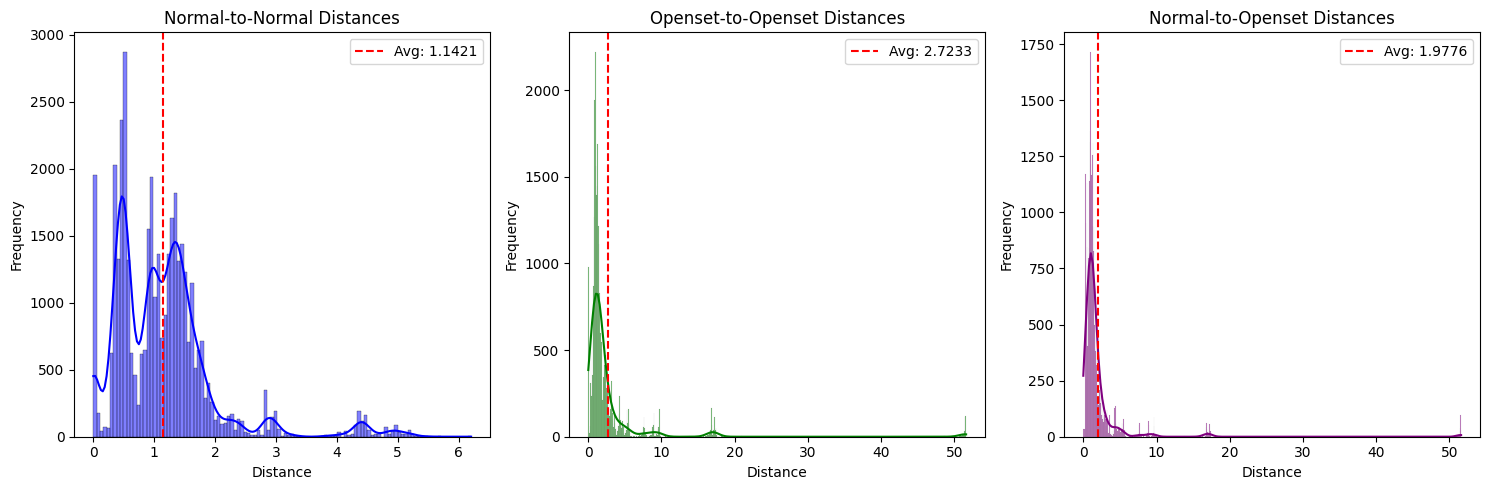

/tmp/ipykernel_732126/1003864884.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([v for v in valid_values], labels=valid_types)


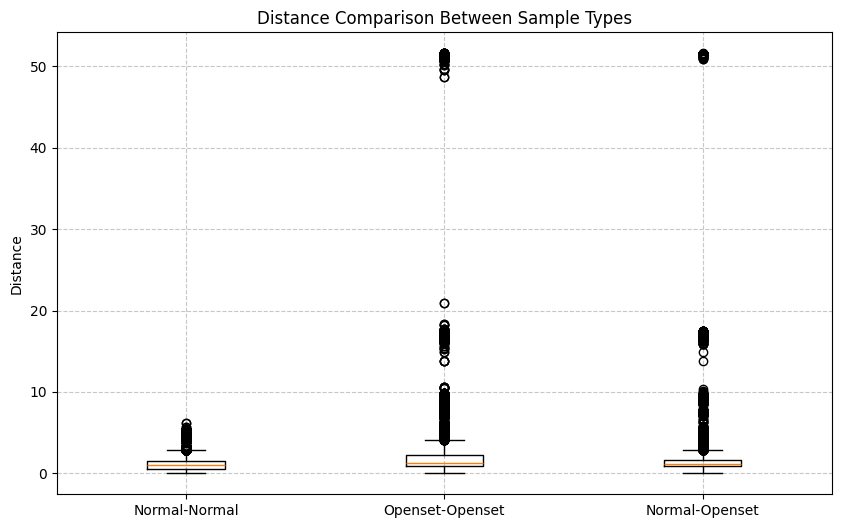

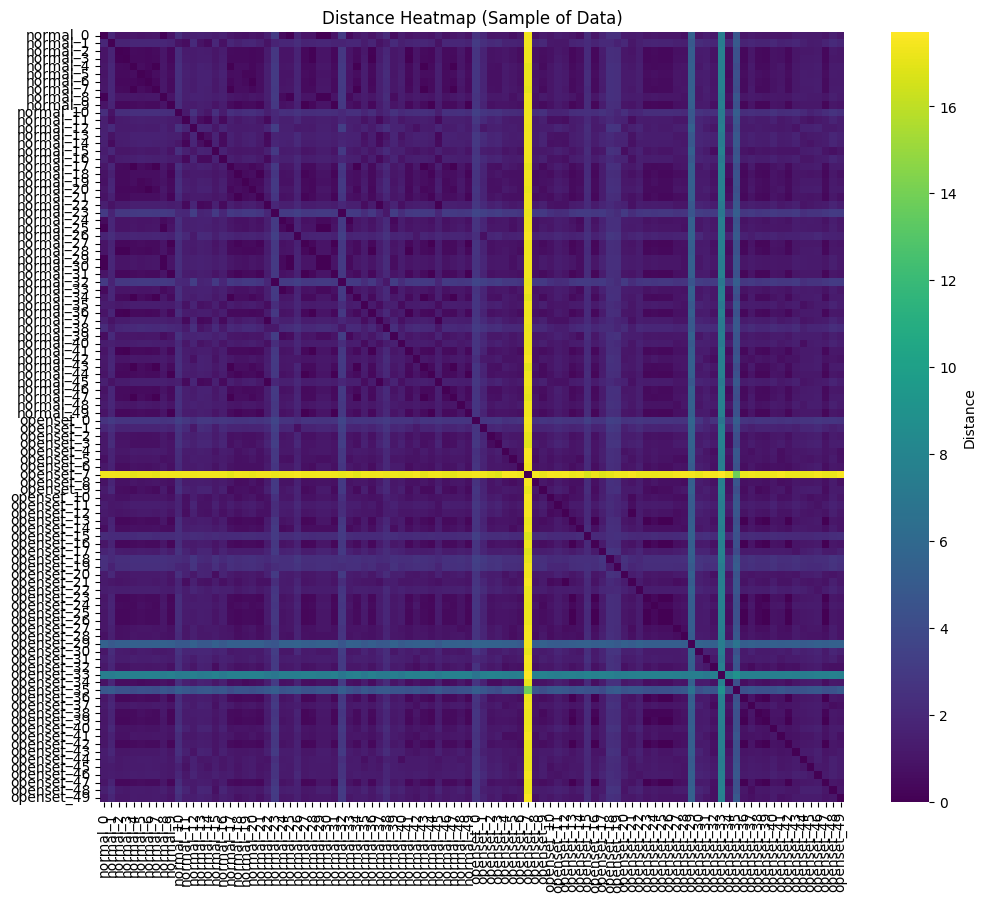


Statistical Summary:
normal_to_normal_avg: 1.1421
normal_to_normal_std: 0.8584
openset_to_openset_avg: 2.7233
openset_to_openset_std: 6.0084
normal_to_openset_avg: 1.9776
normal_to_openset_std: 4.3628
difference_ratio: 1.7315


In [11]:
# After your existing code that computes the TSNE embeddings
output_np = output.detach().numpy()

# Create a directory for saving plots
import os
save_dir = f"./distance_analysis_seed{seed}_nn_openset"
os.makedirs(save_dir, exist_ok=True)

# Run the distance analysis
stats, distance_matrix = analyze_sample_distances(
    embeddings=output_np,
    labels=all_label,
    save_path=save_dir
)

# Optionally, save the results
with open(f"{save_dir}/distance_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

# If you want to save the full distance matrix (can be large)
np.save(f"{save_dir}/distance_matrix.npy", distance_matrix)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd

def analyze_sample_distances(embeddings, labels, save_path=None):
    """
    Analyze and visualize distances between normal and openset samples.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The TSNE embeddings of all samples (normal + openset)
    labels : numpy.ndarray
        Labels for each sample, with -1 indicating openset samples
    save_path : str, optional
        Path to save the visualization figures
    """
    # Convert labels to numpy array if it's not already
    labels = np.array(labels)
    
    # Identify normal and openset samples
    normal_indices = np.where(labels != '-1')[0]
    openset_indices = np.where(labels == '-1')[0]
    
    normal_embeddings = embeddings[normal_indices]
    openset_embeddings = embeddings[openset_indices]
    
    print(f"Number of normal samples: {len(normal_indices)}")
    print(f"Number of openset samples: {len(openset_indices)}")
    
    # Calculate distance matrix for all samples
    distances = euclidean_distances(embeddings)
    
    # 1. Calculate average distances: normal-to-normal, openset-to-openset, normal-to-openset
    normal_to_normal_distances = distances[np.ix_(normal_indices, normal_indices)]
    openset_to_openset_distances = distances[np.ix_(openset_indices, openset_indices)]
    normal_to_openset_distances = distances[np.ix_(normal_indices, openset_indices)]
    
    # Remove self-distances (zeros on diagonal)
    normal_to_normal_avg = normal_to_normal_distances[~np.eye(normal_to_normal_distances.shape[0], dtype=bool)].mean()
    openset_to_openset_avg = openset_to_openset_distances[~np.eye(openset_to_openset_distances.shape[0], dtype=bool)].mean() if len(openset_indices) > 1 else 0
    normal_to_openset_avg = normal_to_openset_distances.mean()
    
    print(f"Average normal-to-normal distance: {normal_to_normal_avg:.4f}")
    print(f"Average openset-to-openset distance: {openset_to_openset_avg:.4f}")
    print(f"Average normal-to-openset distance: {normal_to_openset_avg:.4f}")
    
    # 2. Calculate minimum distances for each sample
    # For each openset sample, find distance to nearest normal sample
    openset_to_nearest_normal = np.min(normal_to_openset_distances, axis=0)
    
    # For each normal sample, find distance to nearest normal sample (excluding self)
    normal_to_nearest_normal = []
    for i in range(len(normal_indices)):
        # Get distances to all other normal samples
        distances_to_others = normal_to_normal_distances[i, :]
        # Set distance to self as infinity to exclude it
        distances_to_others[i] = np.inf
        # Find minimum distance
        normal_to_nearest_normal.append(np.min(distances_to_others))
    
    normal_to_nearest_normal = np.array(normal_to_nearest_normal)
    
    # Calculate statistics
    openset_nearest_avg = openset_to_nearest_normal.mean()
    openset_nearest_std = openset_to_nearest_normal.std()
    normal_nearest_avg = normal_to_nearest_normal.mean()
    normal_nearest_std = normal_to_nearest_normal.std()
    
    print(f"\nAverage distance from openset samples to nearest normal sample: {openset_nearest_avg:.4f} ± {openset_nearest_std:.4f}")
    print(f"Average distance from normal samples to nearest normal sample: {normal_nearest_avg:.4f} ± {normal_nearest_std:.4f}")
    print(f"Ratio (openset-to-nearest-normal / normal-to-nearest-normal): {openset_nearest_avg / normal_nearest_avg:.4f}")
    
    # 3. Visualization of nearest neighbor distances
    plt.figure(figsize=(12, 6))
    
    # Plot distributions
    plt.subplot(121)
    sns.histplot(normal_to_nearest_normal, kde=True, color='blue', label='Normal samples')
    sns.histplot(openset_to_nearest_normal, kde=True, color='red', alpha=0.7, label='Openset samples')
    plt.axvline(x=normal_nearest_avg, color='blue', linestyle='--', label=f'Normal avg: {normal_nearest_avg:.4f}')
    plt.axvline(x=openset_nearest_avg, color='red', linestyle='--', label=f'Openset avg: {openset_nearest_avg:.4f}')
    plt.title('Distribution of Distances to Nearest Normal Sample')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Boxplot comparison
    plt.subplot(122)
    box_data = [normal_to_nearest_normal, openset_to_nearest_normal]
    plt.boxplot(box_data, labels=['Normal samples', 'Openset samples'])
    plt.title('Comparison of Distances to Nearest Normal Sample')
    plt.ylabel('Distance')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}/nearest_neighbor_distances.png", dpi=300)
    plt.show()
    
    # 4. Detailed analysis of each sample (both normal and openset)
    # For openset samples
    openset_details = pd.DataFrame({
        'sample_id': openset_indices,
        'sample_type': 'openset',
        'distance_to_nearest_normal': openset_to_nearest_normal,
        'nearest_normal_idx': [normal_indices[np.argmin(normal_to_openset_distances[:, i])] for i in range(len(openset_indices))],
        'nearest_normal_label': [labels[normal_indices[np.argmin(normal_to_openset_distances[:, i])]] for i in range(len(openset_indices))]
    })
    
    # For normal samples
    normal_details = []
    for i, idx in enumerate(normal_indices):
        # Get distances to all other normal samples
        distances_to_others = normal_to_normal_distances[i, :]
        # Set distance to self as infinity to exclude it
        distances_to_others[i] = np.inf
        # Find minimum distance and corresponding index
        min_distance = np.min(distances_to_others)
        min_idx_local = np.argmin(distances_to_others)
        # Convert local index to global index
        min_idx_global = normal_indices[min_idx_local]
        
        normal_details.append({
            'sample_id': idx,
            'sample_type': 'normal',
            'distance_to_nearest_normal': min_distance,
            'nearest_normal_idx': min_idx_global,
            'nearest_normal_label': labels[min_idx_global],
            'own_label': labels[idx]
        })
    
    normal_details_df = pd.DataFrame(normal_details)
    
    # Combine both dataframes
    all_details = pd.concat([openset_details, normal_details_df], ignore_index=True)
    
    # Sort by distance (ascending)
    openset_details_sorted = openset_details.sort_values(by='distance_to_nearest_normal')
    normal_details_sorted = normal_details_df.sort_values(by='distance_to_nearest_normal', ascending=False)
    
    print("\nDetails for openset samples (sorted by distance to nearest normal sample):")
    print(openset_details_sorted.head(10))  # Show top 10
    
    print("\nDetails for normal samples (sorted by distance to nearest normal sample):")
    print(normal_details_sorted.head(10))  # Show top 10
    # 5. Visualize the closest and furthest openset samples
    if len(openset_indices) >= 5:
        closest_indices = openset_details.iloc[:5]['sample_id'].values
        furthest_indices = openset_details.iloc[-5:]['sample_id'].values
        
        # Create a plot showing the embeddings and highlighting these samples
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        plt.scatter(embeddings[normal_indices, 0], embeddings[normal_indices, 1], c='blue', alpha=0.5, s=20, label='Normal samples')
        plt.scatter(embeddings[openset_indices, 0], embeddings[openset_indices, 1], c='red', alpha=0.5, s=20, label='Openset samples')
        plt.scatter(embeddings[closest_indices, 0], embeddings[closest_indices, 1], c='green', s=100, marker='*', label='Closest openset samples')
        
        for i, idx in enumerate(closest_indices):
            nearest_normal = openset_details[openset_details['sample_id'] == idx]['nearest_normal_idx'].values[0]
            plt.plot([embeddings[idx, 0], embeddings[nearest_normal, 0]], 
                     [embeddings[idx, 1], embeddings[nearest_normal, 1]], 'g--', alpha=0.7)
        
        plt.title('Closest Openset Samples to Normal Samples')
        plt.legend()
        
        plt.subplot(122)
        plt.scatter(embeddings[normal_indices, 0], embeddings[normal_indices, 1], c='blue', alpha=0.5, s=20, label='Normal samples')
        plt.scatter(embeddings[openset_indices, 0], embeddings[openset_indices, 1], c='red', alpha=0.5, s=20, label='Openset samples')
        plt.scatter(embeddings[furthest_indices, 0], embeddings[furthest_indices, 1], c='purple', s=100, marker='*', label='Furthest openset samples')
        
        for i, idx in enumerate(furthest_indices):
            nearest_normal = openset_details[openset_details['sample_id'] == idx]['nearest_normal_idx'].values[0]
            plt.plot([embeddings[idx, 0], embeddings[nearest_normal, 0]], 
                     [embeddings[idx, 1], embeddings[nearest_normal, 1]], 'm--', alpha=0.7)
        
        plt.title('Furthest Openset Samples from Normal Samples')
        plt.legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/closest_furthest_openset.png", dpi=300)
        plt.show()
    
    # 6. Return compiled statistics
    stats = {
        "normal_to_normal_avg": normal_to_normal_avg,
        "openset_to_openset_avg": openset_to_openset_avg,
        "normal_to_openset_avg": normal_to_openset_avg,
        "openset_to_nearest_normal_avg": openset_nearest_avg,
        "openset_to_nearest_normal_std": openset_nearest_std,
        "normal_to_nearest_normal_avg": normal_nearest_avg,
        "normal_to_nearest_normal_std": normal_nearest_std,
        "nearest_distance_ratio": openset_nearest_avg / normal_nearest_avg
    }
    
    nearest_distances = {
        "openset_to_nearest_normal": openset_to_nearest_normal,
        "normal_to_nearest_normal": normal_to_nearest_normal
    }
    
    return stats, nearest_distances, openset_details, normal_details_df

Number of normal samples: 200
Number of openset samples: 171
Average normal-to-normal distance: 1.1421
Average openset-to-openset distance: 2.7233
Average normal-to-openset distance: 1.9776

Average distance from openset samples to nearest normal sample: 1.4013 ± 4.2692
Average distance from normal samples to nearest normal sample: 0.1500 ± 0.4760
Ratio (openset-to-nearest-normal / normal-to-nearest-normal): 9.3400


/tmp/ipykernel_732126/2229840066.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Normal samples', 'Openset samples'])


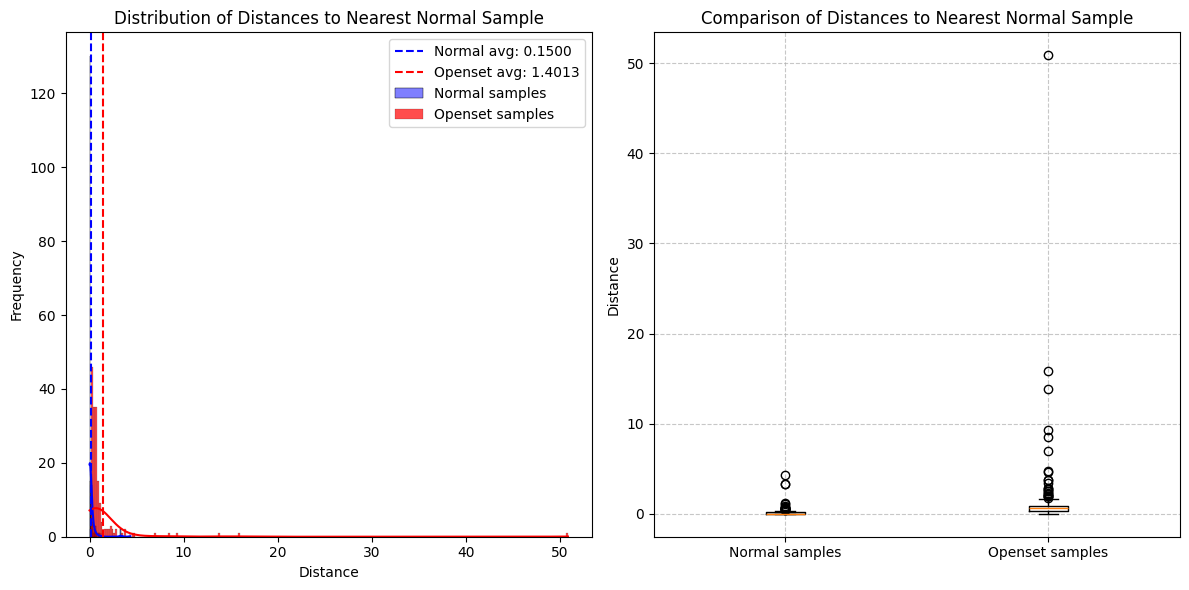


Details for openset samples (sorted by distance to nearest normal sample):
     sample_id sample_type  distance_to_nearest_normal  nearest_normal_idx  \
139        339     openset                2.107342e-08                  60   
166        366     openset                1.661228e-01                  60   
149        349     openset                2.175675e-01                 191   
23         223     openset                2.748236e-01                 102   
76         276     openset                2.775152e-01                 140   
28         228     openset                2.903447e-01                  60   
6          206     openset                2.903447e-01                  60   
0          200     openset                2.903447e-01                  60   
41         241     openset                2.903447e-01                  60   
36         236     openset                2.903447e-01                  60   

    nearest_normal_label  
139             fakebank  
166        

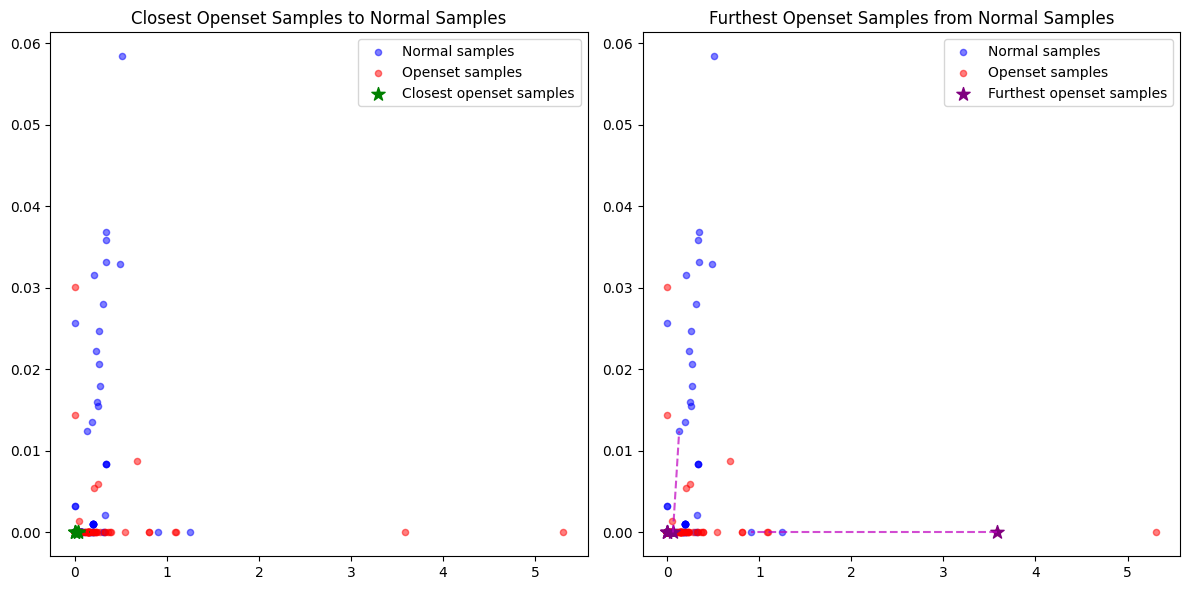

In [13]:
# 在你现有的代码之后添加这些
output_np = output.detach().numpy()

# 创建保存图表的目录
import os
save_dir = f"./distance_analysis_seed{seed}"
os.makedirs(save_dir, exist_ok=True)

# 运行距离分析
stats, nearest_distances, openset_details, normal_details = analyze_sample_distances(
    embeddings=output_np,
    labels=all_label,
    save_path=save_dir
)

# 可选，保存结果
with open(f"{save_dir}/distance_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

with open(f"{save_dir}/nearest_distances.pkl", "wb") as f:
    pickle.dump(nearest_distances, f)

## GraphSAGE model experiments

In [4]:
from utils import load_config
from loadDataset import LoadDataset
from trainModule import TestModule
import os

In [5]:
seeds = [19, 22, 31, 888] ## in islab_14 server

In [6]:
for seed in seeds:
    dataset_folder = f"/home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_{seed}"
    for exp in os.listdir(dataset_folder):
        if os.path.isdir(os.path.join(dataset_folder, exp)):
            config = load_config(os.path.join(dataset_folder, exp, 'config.json'))
            config_path = os.path.join(dataset_folder, exp, 'config.json')
            # config["paths"]["data"]["embedding_folder"] = "/home/manying/Projects/fcgFewShot/embeddings"
            print(f"Seed: {seed}, Experiment: {exp}")
            print(f"Config: {config_path}")
            dataset = LoadDataset(config)
            test_module = TestModule(config_path, dataset, config)
            test_module.temp_eval()
            print("\n")

Seed: 19, Experiment: 10way_5shot_ProtoNet_without_pretrain_20250105_081657
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_5shot_ProtoNet_without_pretrain_20250105_081657/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...


/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Testing accuracy: 0.5861
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.78it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5527
Finish evaluation


Seed: 19, Experiment: 5way_5shot_NnNet_with_pretrain_20250105_032753
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_5shot_NnNet_with_pretrain_20250105_032753/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided.

Testing: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.50it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.32it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


Testing accuracy: 0.8888
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.62it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.92it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8306
Finish evaluation


Seed: 19, Experiment: 10way_5shot_ProtoNet_with_pretrain_20250105_071701
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_5shot_ProtoNet_with_pretrain_20250105_071701/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Testing accuracy: 0.5540
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5145
Finish evaluation


Seed: 19, Experiment: 5way_5shot_ProtoNet_without_pretrain_20250105_025403
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_5shot_ProtoNet_without_pretrain_20250105_025403/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is n

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


Testing accuracy: 0.6837
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6728
Finish evaluation


Seed: 19, Experiment: 5way_10shot_ProtoNet_with_pretrain_20250105_045638
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_10shot_ProtoNet_with_pretrain_20250105_045638/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


Testing accuracy: 0.6242
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.83it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.78it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6463
Finish evaluation


Seed: 19, Experiment: 5way_5shot_ProtoNet_with_pretrain_20250105_020921
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_5shot_ProtoNet_with_pretrain_20250105_020921/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not pro

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.33it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


Testing accuracy: 0.6523
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.97it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.66it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6497
Finish evaluation


Seed: 19, Experiment: 10way_10shot_NnNet_with_pretrain_20250105_160710
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_10shot_NnNet_with_pretrain_20250105_160710/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provi

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Testing accuracy: 0.9095
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8339
Finish evaluation


Seed: 19, Experiment: 10way_10shot_NnNet_without_pretrain_20250105_164110
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_10shot_NnNet_without_pretrain_20250105_164110/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Testing accuracy: 0.9219
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8357
Finish evaluation


Seed: 19, Experiment: 10way_10shot_ProtoNet_without_pretrain_20250105_153205
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_10shot_ProtoNet_without_pretrain_20250105_153205/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path 

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Testing accuracy: 0.5522
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5415
Finish evaluation


Seed: 19, Experiment: 10way_10shot_ProtoNet_with_pretrain_20250105_103212
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_10shot_ProtoNet_with_pretrain_20250105_103212/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Testing accuracy: 0.5102
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5075
Finish evaluation


Seed: 19, Experiment: 5way_10shot_NnNet_without_pretrain_20250105_070333
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_10shot_NnNet_without_pretrain_20250105_070333/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


Testing accuracy: 0.9349
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.03it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.54it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.08it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.16it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8828
Finish evaluation


Seed: 19, Experiment: 5way_5shot_NnNet_without_pretrain_20250105_041931
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_5shot_NnNet_without_pretrain_20250105_041931/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not pro

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Testing accuracy: 0.9107
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.15it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8323
Finish evaluation


Seed: 19, Experiment: 5way_10shot_NnNet_with_pretrain_20250105_062416
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_10shot_NnNet_with_pretrain_20250105_062416/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provide

Testing: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


Testing accuracy: 0.9238
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.91it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.12it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.01it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 19.50it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8827
Finish evaluation


Seed: 19, Experiment: 10way_5shot_NnNet_with_pretrain_20250105_090707
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_5shot_NnNet_with_pretrain_20250105_090707/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provide

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Testing accuracy: 0.8679
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.7742
Finish evaluation


Seed: 19, Experiment: 10way_5shot_NnNet_without_pretrain_20250105_094729
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/10way_5shot_NnNet_without_pretrain_20250105_094729/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


Testing accuracy: 0.8879
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.51it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.7778
Finish evaluation


Seed: 19, Experiment: 5way_10shot_ProtoNet_without_pretrain_20250105_053721
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_19/5way_10shot_ProtoNet_without_pretrain_20250105_053721/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_19/word2vec/testData.pkl...
Finish setting up the testing module
Model path is

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


Testing accuracy: 0.6510
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.45it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.04it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6626
Finish evaluation


Seed: 22, Experiment: 10way_10shot_NnNet_without_pretrain_20250107_005245
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_10shot_NnNet_without_pretrain_20250107_005245/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not

Testing: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Testing accuracy: 0.8391
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9188
Finish evaluation


Seed: 22, Experiment: 5way_5shot_NnNet_without_pretrain_20250106_024049
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_5shot_NnNet_without_pretrain_20250106_024049/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not pro

Testing: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


Testing accuracy: 0.8324
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9178
Finish evaluation


Seed: 22, Experiment: 10way_5shot_NnNet_without_pretrain_20250106_193810
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_5shot_NnNet_without_pretrain_20250106_193810/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Testing accuracy: 0.8007
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8908
Finish evaluation


Seed: 22, Experiment: 5way_5shot_NnNet_with_pretrain_20250106_021633
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_5shot_NnNet_with_pretrain_20250106_021633/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


Testing accuracy: 0.8326
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9315
Finish evaluation


Seed: 22, Experiment: 5way_5shot_ProtoNet_with_pretrain_20250106_003511
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_5shot_ProtoNet_with_pretrain_20250106_003511/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:07<00:00, 14.06it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]


Testing accuracy: 0.6740
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8689
Finish evaluation


Seed: 22, Experiment: 5way_10shot_NnNet_without_pretrain_20250106_090033
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_10shot_NnNet_without_pretrain_20250106_090033/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


Testing accuracy: 0.8769
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9561
Finish evaluation


Seed: 22, Experiment: 5way_5shot_ProtoNet_without_pretrain_20250106_015521
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_5shot_ProtoNet_without_pretrain_20250106_015521/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path is n

Testing: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Testing accuracy: 0.6699
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8478
Finish evaluation


Seed: 22, Experiment: 10way_5shot_ProtoNet_with_pretrain_20250106_092430
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_5shot_ProtoNet_with_pretrain_20250106_092430/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Testing accuracy: 0.5589
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.7948
Finish evaluation


Seed: 22, Experiment: 5way_10shot_NnNet_with_pretrain_20250106_083127
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_10shot_NnNet_with_pretrain_20250106_083127/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.42it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


Testing accuracy: 0.8707
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9572
Finish evaluation


Seed: 22, Experiment: 10way_5shot_ProtoNet_without_pretrain_20250106_160527
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_5shot_ProtoNet_without_pretrain_20250106_160527/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path is

Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Testing accuracy: 0.5967
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.7999
Finish evaluation


Seed: 22, Experiment: 10way_10shot_ProtoNet_without_pretrain_20250106_220756
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_10shot_ProtoNet_without_pretrain_20250106_220756/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path 

Testing: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Testing accuracy: 0.6605
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8344
Finish evaluation


Seed: 22, Experiment: 10way_10shot_ProtoNet_with_pretrain_20250106_202101
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_10shot_ProtoNet_with_pretrain_20250106_202101/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Testing accuracy: 0.5661
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8307
Finish evaluation


Seed: 22, Experiment: 5way_10shot_ProtoNet_with_pretrain_20250106_030307
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_10shot_ProtoNet_with_pretrain_20250106_030307/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 14.18it/s]


Testing accuracy: 0.6580
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8732
Finish evaluation


Seed: 22, Experiment: 10way_5shot_NnNet_with_pretrain_20250106_174033
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_5shot_NnNet_with_pretrain_20250106_174033/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Testing accuracy: 0.7861
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9014
Finish evaluation


Seed: 22, Experiment: 10way_10shot_NnNet_with_pretrain_20250106_235338
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/10way_10shot_NnNet_with_pretrain_20250106_235338/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Testing accuracy: 0.8399
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9334
Finish evaluation


Seed: 22, Experiment: 5way_10shot_ProtoNet_without_pretrain_20250106_063314
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_22/5way_10shot_ProtoNet_without_pretrain_20250106_063314/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_22/word2vec/testData.pkl...
Finish setting up the testing module
Model path is

Testing: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:07<00:00, 14.07it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:07<00:00, 14.06it/s]


Testing accuracy: 0.7236
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8740
Finish evaluation


Seed: 31, Experiment: 10way_5shot_NnNet_without_pretrain_20250104_024800
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_5shot_NnNet_without_pretrain_20250104_024800/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


Testing accuracy: 0.8416
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8275
Finish evaluation


Seed: 31, Experiment: 10way_5shot_NnNet_with_pretrain_20250103_230348
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_5shot_NnNet_with_pretrain_20250103_230348/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provide

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Testing accuracy: 0.8391
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8219
Finish evaluation


Seed: 31, Experiment: 10way_10shot_NnNet_without_pretrain_20250104_114157
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_10shot_NnNet_without_pretrain_20250104_114157/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Testing accuracy: 0.8410
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8853
Finish evaluation


Seed: 31, Experiment: 5way_10shot_ProtoNet_with_pretrain_20250102_194528
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_10shot_ProtoNet_with_pretrain_20250102_194528/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


Testing accuracy: 0.7124
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.21it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:11<00:00,  9.08it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:11<00:00,  9.06it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6804
Finish evaluation


Seed: 31, Experiment: 5way_5shot_NnNet_with_pretrain_20250102_170004
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_5shot_NnNet_with_pretrain_20250102_170004/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provided.

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


Testing accuracy: 0.8821
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.18it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00, 10.00it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.10it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8765
Finish evaluation


Seed: 31, Experiment: 10way_5shot_ProtoNet_with_pretrain_20250102_224006
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_5shot_ProtoNet_with_pretrain_20250102_224006/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Testing accuracy: 0.6269
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5494
Finish evaluation


Seed: 31, Experiment: 5way_5shot_ProtoNet_without_pretrain_20250102_161201
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_5shot_ProtoNet_without_pretrain_20250102_161201/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is n

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


Testing accuracy: 0.7259
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:11<00:00,  9.08it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.90it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.7233
Finish evaluation


Seed: 31, Experiment: 5way_10shot_ProtoNet_without_pretrain_20250102_200528
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_10shot_ProtoNet_without_pretrain_20250102_200528/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


Testing accuracy: 0.7279
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.41it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.7201
Finish evaluation


Seed: 31, Experiment: 5way_10shot_NnNet_with_pretrain_20250102_204958
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_10shot_NnNet_with_pretrain_20250102_204958/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provide

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


Testing accuracy: 0.8913
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9207
Finish evaluation


Seed: 31, Experiment: 10way_10shot_ProtoNet_without_pretrain_20250104_083309
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_10shot_ProtoNet_without_pretrain_20250104_083309/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path 

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Testing accuracy: 0.6765
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6616
Finish evaluation


Seed: 31, Experiment: 10way_10shot_NnNet_with_pretrain_20250104_101337
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_10shot_NnNet_with_pretrain_20250104_101337/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not provi

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


Testing accuracy: 0.8534
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8868
Finish evaluation


Seed: 31, Experiment: 10way_5shot_ProtoNet_without_pretrain_20250103_053643
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_5shot_ProtoNet_without_pretrain_20250103_053643/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Testing accuracy: 0.6541
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5978
Finish evaluation


Seed: 31, Experiment: 5way_5shot_ProtoNet_with_pretrain_20250102_133115
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_5shot_ProtoNet_with_pretrain_20250102_133115/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not pro

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


Testing accuracy: 0.7053
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6840
Finish evaluation


Seed: 31, Experiment: 5way_5shot_NnNet_without_pretrain_20250102_184923
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_5shot_NnNet_without_pretrain_20250102_184923/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not pro

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Testing accuracy: 0.8850
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.31it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:11<00:00,  9.08it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.53it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8807
Finish evaluation


Seed: 31, Experiment: 10way_10shot_ProtoNet_with_pretrain_20250104_041314
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/10way_10shot_ProtoNet_with_pretrain_20250104_041314/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not

Testing: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Testing accuracy: 0.6547
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5608
Finish evaluation


Seed: 31, Experiment: 5way_10shot_NnNet_without_pretrain_20250102_214038
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_31/5way_10shot_NnNet_without_pretrain_20250102_214038/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_31/word2vec/testData.pkl...
Finish setting up the testing module
Model path is not p

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Testing accuracy: 0.8897
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.21it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9215
Finish evaluation


Seed: 888, Experiment: 10way_10shot_ProtoNet_without_pretrain_20250109_071451
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_10shot_ProtoNet_without_pretrain_20250109_071451/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model 

Testing: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Testing accuracy: 0.7240
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.03it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.4928
Finish evaluation


Seed: 888, Experiment: 10way_5shot_NnNet_with_pretrain_20250108_221055
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_5shot_NnNet_with_pretrain_20250108_221055/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Testing accuracy: 0.8005
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8063
Finish evaluation


Seed: 888, Experiment: 10way_5shot_ProtoNet_without_pretrain_20250108_204554
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_5shot_ProtoNet_without_pretrain_20250108_204554/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model pa

Testing: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Testing accuracy: 0.7023
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5066
Finish evaluation


Seed: 888, Experiment: 5way_5shot_ProtoNet_without_pretrain_20250108_023705
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_5shot_ProtoNet_without_pretrain_20250108_023705/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model path

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


Testing accuracy: 0.7928
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.6027
Finish evaluation


Seed: 888, Experiment: 5way_5shot_NnNet_without_pretrain_20250108_070635
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_5shot_NnNet_without_pretrain_20250108_070635/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model path is no

Testing: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Testing accuracy: 0.8934
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8550
Finish evaluation


Seed: 888, Experiment: 5way_10shot_NnNet_without_pretrain_20250108_125131
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_10shot_NnNet_without_pretrain_20250108_125131/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model path is 

Testing: 100%|██████████| 100/100 [00:10<00:00,  9.23it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.58it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


Testing accuracy: 0.9265
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.9062
Finish evaluation


Seed: 888, Experiment: 10way_10shot_NnNet_without_pretrain_20250109_150534
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_10shot_NnNet_without_pretrain_20250109_150534/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model path i

Testing: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Testing accuracy: 0.8464
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8872
Finish evaluation


Seed: 888, Experiment: 10way_10shot_ProtoNet_with_pretrain_20250108_235404
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_10shot_ProtoNet_with_pretrain_20250108_235404/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Testing accuracy: 0.6531
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.4836
Finish evaluation


Seed: 888, Experiment: 10way_10shot_NnNet_with_pretrain_20250109_141539
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_10shot_NnNet_with_pretrain_20250109_141539/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Testing accuracy: 0.8374
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8589
Finish evaluation


Seed: 888, Experiment: 5way_10shot_ProtoNet_with_pretrain_20250108_072946
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_10shot_ProtoNet_with_pretrain_20250108_072946/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.25it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.50it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


Testing accuracy: 0.7816
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5750
Finish evaluation


Seed: 888, Experiment: 5way_5shot_NnNet_with_pretrain_20250108_062453
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_5shot_NnNet_with_pretrain_20250108_062453/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.83it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


Testing accuracy: 0.8912
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8530
Finish evaluation


Seed: 888, Experiment: 5way_10shot_ProtoNet_without_pretrain_20250108_111936
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_10shot_ProtoNet_without_pretrain_20250108_111936/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model pa

Testing: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Testing accuracy: 0.8241
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5819
Finish evaluation


Seed: 888, Experiment: 5way_10shot_NnNet_with_pretrain_20250108_120955
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_10shot_NnNet_with_pretrain_20250108_120955/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.76it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.22it/s]


Testing accuracy: 0.9137
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.8976
Finish evaluation


Seed: 888, Experiment: 10way_5shot_ProtoNet_with_pretrain_20250108_132125
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_5shot_ProtoNet_with_pretrain_20250108_132125/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Testing accuracy: 0.6524
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5003
Finish evaluation


Seed: 888, Experiment: 5way_5shot_ProtoNet_with_pretrain_20250107_224741
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/5way_5shot_ProtoNet_with_pretrain_20250107_224741/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...


/home/mandy/Projects/few_shot_fcg/trainModule.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pretrainModel.load_state_dict(torch.load(pretrainModelPath, map_loca

Finish setting up the testing module
Model path is not provided. Using the best model...
Record evaluation log...
Ablation evaluation... (testing dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.33it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Testing accuracy: 0.7806
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]
/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Testing accuracy: 0.5926
Finish evaluation


Seed: 888, Experiment: 10way_5shot_NnNet_without_pretrain_20250108_230531
Config: /home/mandy/Projects/few_shot_fcg/checkpoints/x86_64_withVal_withPretrain_ghidra_888/10way_5shot_NnNet_without_pretrain_20250108_230531/config.json
Loading all datasets...
train dataset shape: (1180, 16)
train dataset family number: 59
test dataset shape: (200, 16)
test dataset family number: 10
val dataset shape: (200, 16)
val dataset family number: 10
Setting up the testing module...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec...
Loading validation data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/valData.pkl...
Loading testing data...
Loading data from /mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/x86_64_withVal_withPretrain_ghidra_888/word2vec/testData.pkl...
Finish setting up the testing module
Model path is 

Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Testing accuracy: 0.8140
Ablation evaluation... (validation dataset)
Epoch 1


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 2


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 3


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 4


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 5


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 6


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 7


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Epoch 8


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Epoch 9


Testing: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 10


Testing: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]

Testing accuracy: 0.8178
Finish evaluation


